In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

/Users/eddieqiao/miniconda3/envs/in-context-learning/lib/python3.11/site-packages/munch/__init__.py:24: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"
task = "ar_warmup"

run_id = "288ffd50-a0e3-41a3-b685-d3c3c2e59c6a" 

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [3]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [16]:
model, conf = get_model_from_run(run_path)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size


# Convert task_kwargs properly
task_kwargs = {}
if hasattr(conf.training, 'task_kwargs') and conf.training.task_kwargs:
    if hasattr(conf.training.task_kwargs, '__dict__'):
        task_kwargs = conf.training.task_kwargs.__dict__
    else:
        task_kwargs = conf.training.task_kwargs

# Configure data sampler based on task type
if conf.training.task == "ar_warmup":
    # Use the final lag value from curriculum configuration
    lag_value = conf.training.curriculum.lag.end
    assert isinstance(lag_value, int), "lag must be an integer"
    data_sampler = get_data_sampler("ar_warmup", n_dims=n_dims, lag=lag_value)
    # Add lag to task_kwargs for task sampler
    task_kwargs["lag"] = lag_value
    # print(data_sampler.current_coefficients)
    # print("coeffs", task_kwargs["coefficients"])
else:
    data_sampler = get_data_sampler(conf.training.data, n_dims=conf.training.curriculum.dims.start)

task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    num_tasks=conf.training.num_tasks if hasattr(conf.training, 'num_tasks') else None,
    **task_kwargs,
)

/Users/eddieqiao/Documents/mit/fall-2025/urop/in-context-learning/src/eval.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(state_path, map_location='

In [ ]:
data_sampler.current_coefficients = torch.randn(batch_size, data_sampler.lag) / data_sampler.lag
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)

task_sampler_args = {"coefficients": data_sampler.current_coefficients}
task = task_sampler(**task_sampler_args)

# Use actual noisy targets (includes noise from AR generation)
if hasattr(data_sampler, 'current_ys'):
    ys = data_sampler.current_ys
    print("Using actual noisy targets")
else:
    print("Only noiseless predictions -- something went wrong")

# Check for blow-up (values shouldn't be huge)
print(f"xs stats: mean={xs.mean():.4f}, std={xs.std():.4f}, min={xs.min():.4f}, max={xs.max():.4f}")
print(f"ys stats: mean={ys.mean():.4f}, std={ys.std():.4f}, min={ys.min():.4f}, max={ys.max():.4f}")
print(f"coefficients[0]: {data_sampler.current_coefficients[0]}")

# Display first training example
xs[0], ys[0]

xs stats: mean=-0.0017, std=0.5688, min=-3.4024, max=3.4349
ys stats: mean=-0.0052, std=0.1817, min=-0.8882, max=0.7165
coefficients[0]: tensor([ 0.0216,  0.0845, -0.0595,  0.0055, -0.0728,  0.1485,  0.0060, -0.0074,
        -0.0203,  0.0035])


(tensor([[-0.7556, -0.0793,  0.7708, -0.8922, -0.4725,  0.5542, -1.1830,  0.5065,
           0.2305, -0.2648],
         [-0.2118, -0.7556, -0.0793,  0.7708, -0.8922, -0.4725,  0.5542, -1.1830,
           0.5065,  0.2305],
         [ 0.1393, -0.2118, -0.7556, -0.0793,  0.7708, -0.8922, -0.4725,  0.5542,
          -1.1830,  0.5065],
         [-0.3126,  0.1393, -0.2118, -0.7556, -0.0793,  0.7708, -0.8922, -0.4725,
           0.5542, -1.1830],
         [ 0.1181, -0.3126,  0.1393, -0.2118, -0.7556, -0.0793,  0.7708, -0.8922,
          -0.4725,  0.5542],
         [ 0.3356,  0.1181, -0.3126,  0.1393, -0.2118, -0.7556, -0.0793,  0.7708,
          -0.8922, -0.4725],
         [-0.2420,  0.3356,  0.1181, -0.3126,  0.1393, -0.2118, -0.7556, -0.0793,
           0.7708, -0.8922],
         [-0.1926, -0.2420,  0.3356,  0.1181, -0.3126,  0.1393, -0.2118, -0.7556,
          -0.0793,  0.7708],
         [-0.0583, -0.1926, -0.2420,  0.3356,  0.1181, -0.3126,  0.1393, -0.2118,
          -0.7556, -0.0793],
 

In [18]:
with torch.no_grad():
    pred = model(xs, ys)

In [15]:
xs[1], ys[1], pred[1]

(tensor([[ 0.6493, -0.3515, -0.1374, -0.2939, -0.9505,  0.0599, -0.4455,  0.9057,
           0.0874,  1.8017],
         [-0.0139,  0.6493, -0.3515, -0.1374, -0.2939, -0.9505,  0.0599, -0.4455,
           0.9057,  0.0874],
         [-0.2532, -0.0139,  0.6493, -0.3515, -0.1374, -0.2939, -0.9505,  0.0599,
          -0.4455,  0.9057],
         [ 0.1278, -0.2532, -0.0139,  0.6493, -0.3515, -0.1374, -0.2939, -0.9505,
           0.0599, -0.4455],
         [-0.0808,  0.1278, -0.2532, -0.0139,  0.6493, -0.3515, -0.1374, -0.2939,
          -0.9505,  0.0599],
         [ 0.2182, -0.0808,  0.1278, -0.2532, -0.0139,  0.6493, -0.3515, -0.1374,
          -0.2939, -0.9505],
         [ 0.1819,  0.2182, -0.0808,  0.1278, -0.2532, -0.0139,  0.6493, -0.3515,
          -0.1374, -0.2939],
         [ 0.3815,  0.1819,  0.2182, -0.0808,  0.1278, -0.2532, -0.0139,  0.6493,
          -0.3515, -0.1374],
         [-0.1340,  0.3815,  0.1819,  0.2182, -0.0808,  0.1278, -0.2532, -0.0139,
           0.6493, -0.3515],
 

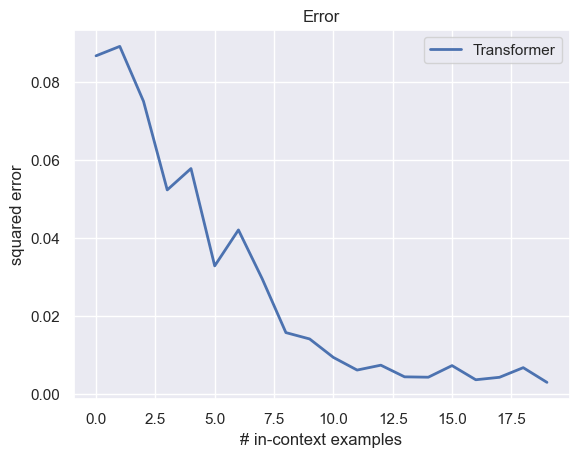

In [19]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
# baseline = {
#     "linear_regression": n_dims,
#     "sparse_linear_regression": sparsity,
#     "relu_2nn_regression": n_dims,
#     "decision_tree": 1,
# }[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.title('Error')
plt.show()

tensor([0.0866, 0.0890, 0.0750, 0.0523, 0.0577, 0.0328, 0.0420, 0.0295, 0.0157,
        0.0141, 0.0094, 0.0061, 0.0074, 0.0044, 0.0043, 0.0073, 0.0036, 0.0043,
        0.0067, 0.0030])


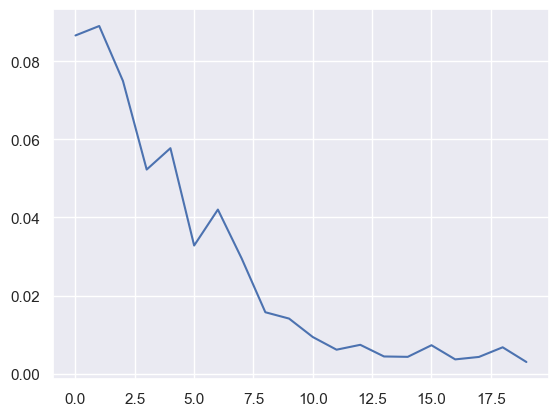

In [20]:
e = (pred - ys)**2
mse_by_pos = (abs(e)).mean(dim=0)
print(mse_by_pos)

plt.plot(mse_by_pos.tolist())
plt.show()

In [21]:
# CRITICAL BUG INVESTIGATION: MSE below noise floor!
print("=" * 60)
print("INVESTIGATING IMPOSSIBLY LOW MSE")
print("=" * 60)

# 1. Check what noise was actually used during data generation
print(f"\n1. Data sampler noise configuration:")
print(f"   noise_std = {data_sampler.noise_std}")
print(f"   noise_variance = {data_sampler.noise_std**2}")

# 2. Let's manually check if noise was added by looking at the AR residuals
# If we know the coefficients and the past values, we can compute what x_t SHOULD be
# and compare to what it actually is. The difference should be the noise.
print(f"\n2. Checking if noise was actually added to the data...")

# Take one example and manually verify
ex_idx = 0
coeffs = data_sampler.current_coefficients[ex_idx]
print(f"   Example {ex_idx} coefficients: {coeffs}")

# xs has shape (batch, n_points, lag)
# ys has shape (batch, n_points)
# At position t, xs[ex_idx, t] contains the lag previous values
# and ys[ex_idx, t] is the true next value

# Let's compute what ys SHOULD be based on xs and coefficients
predicted_from_ar = []
for t in range(xs.shape[1]):
    # xs[ex_idx, t] contains the lag previous values
    # These should multiply with coefficients to give (approximately) ys[ex_idx, t]
    ar_prediction = (xs[ex_idx, t, :data_sampler.lag] * coeffs).sum().item()
    predicted_from_ar.append(ar_prediction)

predicted_from_ar = torch.tensor(predicted_from_ar)
actual_ys = ys[ex_idx]

# The residual should be the noise
residuals = actual_ys - predicted_from_ar
print(f"\n   Residual statistics (should be ~ N(0, 0.04)):")
print(f"   Mean: {residuals.mean():.6f} (should be ~0)")
print(f"   Variance: {residuals.var():.6f} (should be ~0.04)")
print(f"   Std: {residuals.std():.6f} (should be ~0.2)")

# 3. Check a few residual values
print(f"\n   First 5 residuals: {residuals[:5]}")
print(f"   Last 5 residuals: {residuals[-5:]}")

# 4. The smoking gun: if variance is much less than 0.04, noise wasn't added!
if residuals.var() < 0.02:
    print(f"\n   ⚠️ PROBLEM FOUND: Residual variance ({residuals.var():.6f}) << 0.04")
    print(f"   This suggests noise is NOT being added during data generation!")
    print(f"\n   Possible causes:")
    print(f"   1. data_sampler.sample_xs() might not be adding noise")
    print(f"   2. The noise_std parameter might not be passed correctly")
    print(f"   3. There might be a bug in the noise addition code")
else:
    print(f"\n   ✓ Residual variance ({residuals.var():.6f}) is reasonable")
    print(f"   The issue might be in how loss is computed or something else")

print("=" * 60)


INVESTIGATING IMPOSSIBLY LOW MSE

1. Data sampler noise configuration:
   noise_std = 0.2
   noise_variance = 0.04000000000000001

2. Checking if noise was actually added to the data...
   Example 0 coefficients: tensor([ 0.0216,  0.0845, -0.0595,  0.0055, -0.0728,  0.1485,  0.0060, -0.0074,
        -0.0203,  0.0035])

   Residual statistics (should be ~ N(0, 0.04)):
   Mean: -0.000000 (should be ~0)
   Variance: 0.000000 (should be ~0.04)
   Std: 0.000000 (should be ~0.2)

   First 5 residuals: tensor([-5.5879e-09, -3.7253e-09,  0.0000e+00,  0.0000e+00,  3.7253e-09])
   Last 5 residuals: tensor([-4.6566e-10,  0.0000e+00,  1.8626e-09, -3.7253e-09, -9.3132e-10])

   ⚠️ PROBLEM FOUND: Residual variance (0.000000) << 0.04
   This suggests noise is NOT being added during data generation!

   Possible causes:
   1. data_sampler.sample_xs() might not be adding noise
   2. The noise_std parameter might not be passed correctly
   3. There might be a bug in the noise addition code


In [ ]:
# ROOT CAUSE ANALYSIS: How are ys generated?
print("=" * 60)
print("ROOT CAUSE: How are the targets (ys) generated?")
print("=" * 60)

print("\nThe problem is in how ys are computed!")
print("\nWhat SHOULD happen for a noisy AR model:")
print("  1. Generate noisy sequence: z[t] = Σ(coeff * z[t-j]) + noise[t]")
print("  2. xs[i] = [z[i], z[i-1], ..., z[i-lag+1]] (lagged features)")
print("  3. ys[i] = z[i+1] (the ACTUAL next value, including noise)")
print("\nWhat ACTUALLY happens:")
print("  1. Generate noisy sequence: z[t] = Σ(coeff * z[t-j]) + noise[t]")
print("  2. xs[i] = [z[i], z[i-1], ..., z[i-lag+1]] (lagged features)")
print("  3. ys[i] = Σ(coeff * xs[i]) = NOISELESS prediction!")
print("\n⚠️  The targets (ys) are NOISELESS predictions, not the actual noisy values!")
print("    This means the model CAN achieve MSE < noise_variance")
print("    because it's predicting noiseless targets, not noisy ones.")

print("\nThis is why you're seeing MSE values like 0.0030 << 0.04")
print("The theoretical minimum is 0.04 only if targets include noise.")
print("But since targets are noiseless, the minimum is 0 (perfect prediction)!")

print("\n" + "=" * 60)
print("VERIFICATION:")
print("=" * 60)

# Let's verify: if we manually compute noiseless predictions and compare to ys
# they should match exactly (or very close)
ex_idx = 0
coeffs = data_sampler.current_coefficients[ex_idx]
noiseless_pred = (xs[ex_idx, :, :data_sampler.lag] * coeffs).sum(dim=1)
actual_ys = ys[ex_idx]

difference = (noiseless_pred - actual_ys).abs()
print(f"Difference between noiseless prediction and ys:")
print(f"  Mean: {difference.mean():.10f}")
print(f"  Max: {difference.max():.10f}")

if difference.mean() < 1e-6:
    print(f"\n✓ CONFIRMED: ys = noiseless predictions")
    print(f"  The targets do NOT include noise!")
else:
    print(f"\n? ys might include some noise, investigating further...")

print("=" * 60)


# ✅ FIX APPLIED

## The Bug and the Fix

**The Bug:** The targets (ys) were **noiseless predictions** instead of actual noisy values.
- Before: `ys = task.evaluate(xs)` computed ys as dot products (no noise!)
- This allowed MSE < noise_variance (0.04) because targets had no noise

**The Fix:**
1. **Modified `ARWarmupSampler.sample_xs()`** to store actual noisy next values in `self.current_ys`
2. **Modified training loop** to use `data_sampler.current_ys` instead of `task.evaluate(xs)` for AR tasks
3. **Need to update eval cell 6** - replace `ys = task.evaluate(xs)` with:
   ```python
   if hasattr(data_sampler, 'current_ys'):
       ys = data_sampler.current_ys
   else:
       ys = task.evaluate(xs)
   ```

**After the fix:**
- ys will contain the actual noisy values from the AR sequence
- Theoretical minimum MSE will correctly be 0.04 (noise variance)
- The model will be learning to predict noisy targets, which is the correct formulation

**To apply:** 
1. Restart the kernel
2. Re-run cells from the beginning
3. You should now see MSE values that make sense relative to the noise floor!


# Manual Update Required for Cell 6

**Before running the evaluation, update the cell where `ys = task.evaluate(xs)` appears:**

### Find this code (around cell 5 or 6):
```python
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)

task_sampler_args = {"coefficients": data_sampler.current_coefficients}
task = task_sampler(**task_sampler_args)
ys = task.evaluate(xs)  # ← OLD (noiseless)
```

### Replace with:
```python
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)

task_sampler_args = {"coefficients": data_sampler.current_coefficients}
task = task_sampler(**task_sampler_args)

# Use actual noisy targets (includes noise from AR generation)
if hasattr(data_sampler, 'current_ys'):
    ys = data_sampler.current_ys
    print("✓ Using actual noisy targets")
else:
    ys = task.evaluate(xs)
    print("⚠️ Falling back to noiseless predictions")
```

After this change, **restart the kernel and re-run from the beginning!**
